# Electricity Load Diagrams — Exploration

## Objectives
- Understand the structure of the electricity load dataset
- Inspect seasonality and trends
- Identify data quality issues (missing values, scale)
- Frame forecasting and anomaly detection problems


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)


In [3]:
DATA_PATH = Path("../data/raw/LD2011_2014.txt")

df = pd.read_csv(
    DATA_PATH,
    sep=";",
    index_col=0,
    parse_dates=True,
    decimal=","
)

In [4]:

df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.shape

(140256, 370)

In [ ]:
df.isna().sum().describe()


count    370.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [7]:
series_id

'MT_001'

In [6]:
series_id = df.columns[0]
ts = df[series_id]

ts.name = "load"
ts.head()


2011-01-01 00:15:00    0.0
2011-01-01 00:30:00    0.0
2011-01-01 00:45:00    0.0
2011-01-01 01:00:00    0.0
2011-01-01 01:15:00    0.0
Name: load, dtype: float64

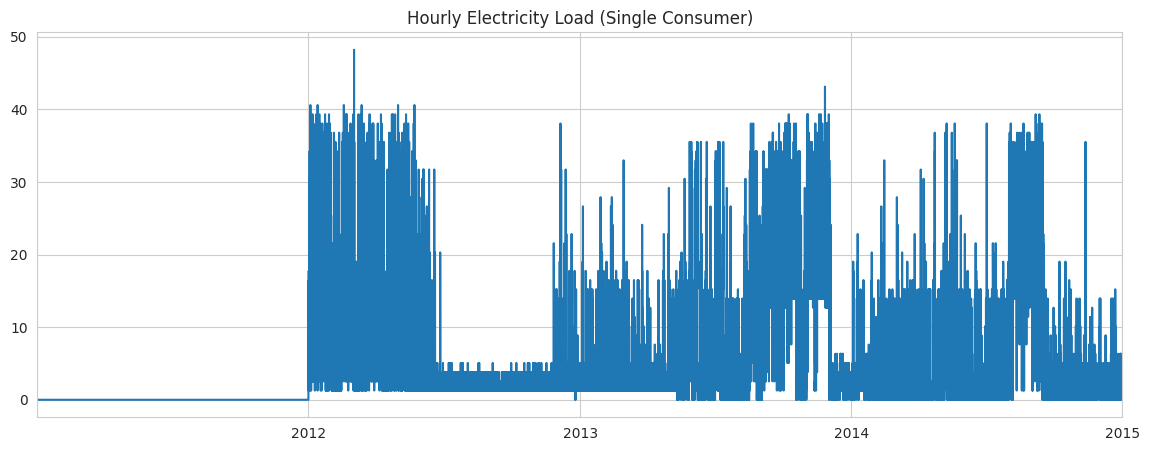

In [9]:
ts.plot(title="Hourly Electricity Load (Single Consumer)")
plt.show()


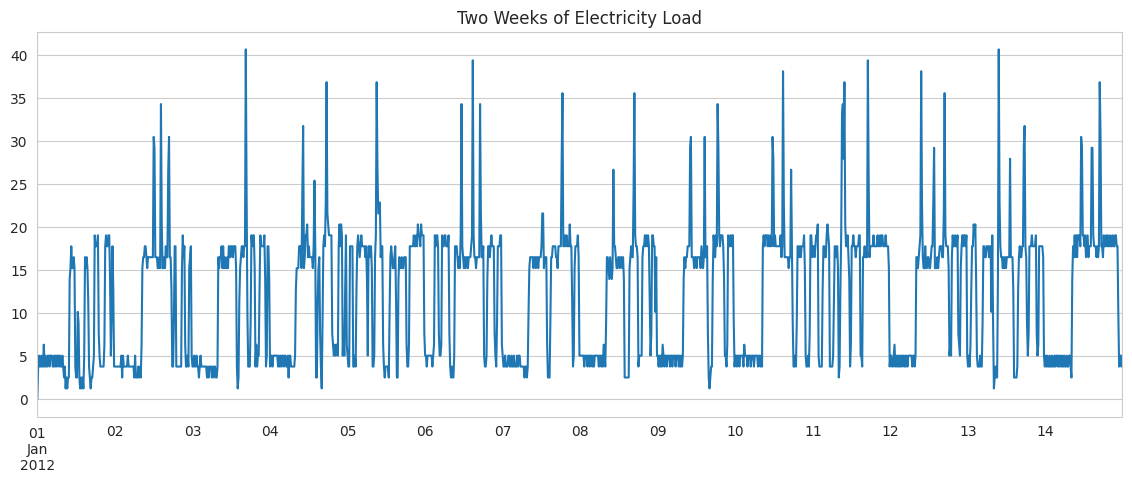

In [10]:
ts["2012-01-01":"2012-01-14"].plot(
    title="Two Weeks of Electricity Load"
)
plt.show()


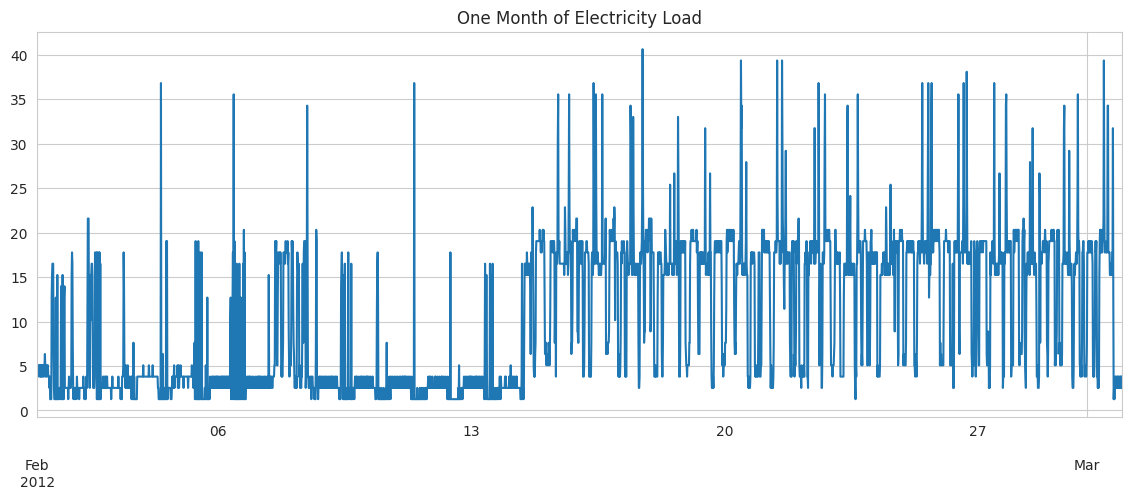

In [11]:
ts["2012-02-01":"2012-03-01"].plot(
    title="One Month of Electricity Load"
)
plt.show()


## Rolling Statistics (Mean & Variance)

Rolling mean and rolling standard deviation are used as a first diagnostic
to assess whether a time series is stationary.

If the statistical properties of the series (mean and variance) change over time,
the series is considered non-stationary.

In this dataset:
- The rolling mean evolves over time, indicating a changing trend
- The rolling standard deviation is not constant, indicating heteroscedasticity

This confirms that the electricity load series is non-stationary, which motivates:
- trend / seasonality decomposition
- window-based learning approaches
- models that do not assume stationarity


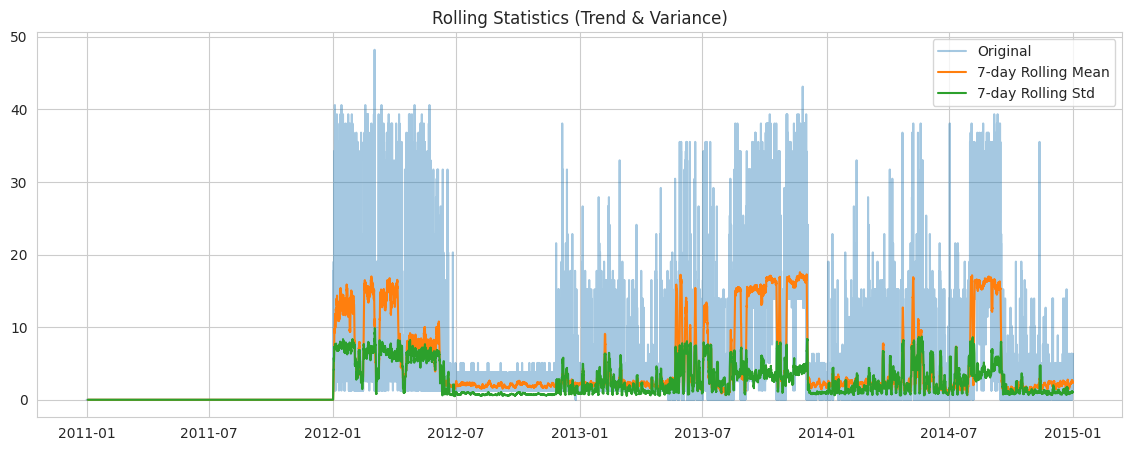

In [12]:
rolling_mean = ts.rolling(window=24*7).mean()
rolling_std = ts.rolling(window=24*7).std()

plt.figure(figsize=(14,5))
plt.plot(ts, alpha=0.4, label="Original")
plt.plot(rolling_mean, label="7-day Rolling Mean")
plt.plot(rolling_std, label="7-day Rolling Std")
plt.legend()
plt.title("Rolling Statistics (Trend & Variance)")
plt.show()


## STL Decomposition (Trend, Seasonality, Residual)

STL decomposition separates a time series into three components:
- Trend: long-term movement
- Seasonality: repeating periodic patterns
- Residual: unexplained variation

Observations:
- The trend component changes slowly over time, reflecting long-term behavior
- The seasonal component is strong and regular, dominated by daily cycles
- The residual component contains spikes and irregular patterns

The residual component is particularly important for anomaly detection,
as anomalies often manifest as large deviations not explained by trend or seasonality.


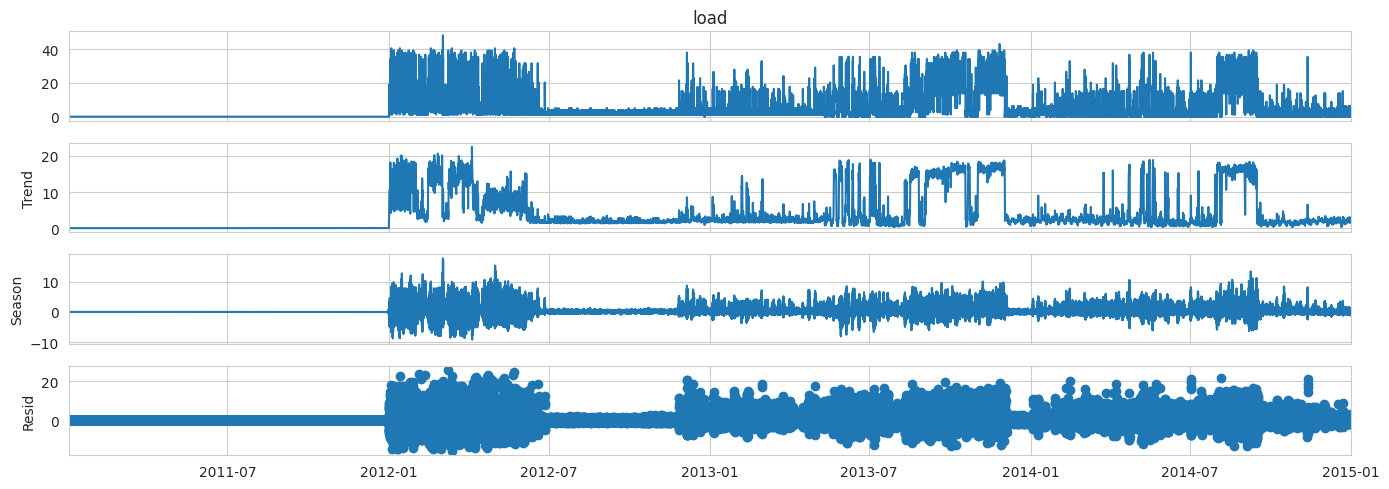

In [14]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=24)
result = stl.fit()

result.plot()
plt.show()


## Autocorrelation and Partial Autocorrelation

Autocorrelation functions (ACF) measure how strongly the series is correlated
with its past values at different lags.

Key observations:
- Strong autocorrelation at lag 24 confirms daily seasonality
- Significant correlations at multiple lags indicate long temporal dependencies

This implies:
- Past values contain useful predictive information
- Window-based forecasting models are appropriate
- Simple IID assumptions are violated


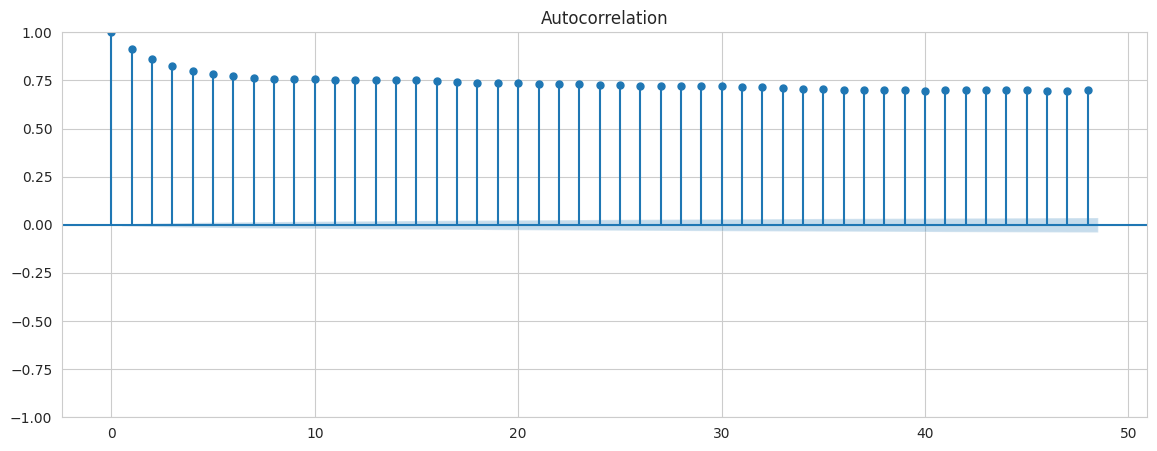

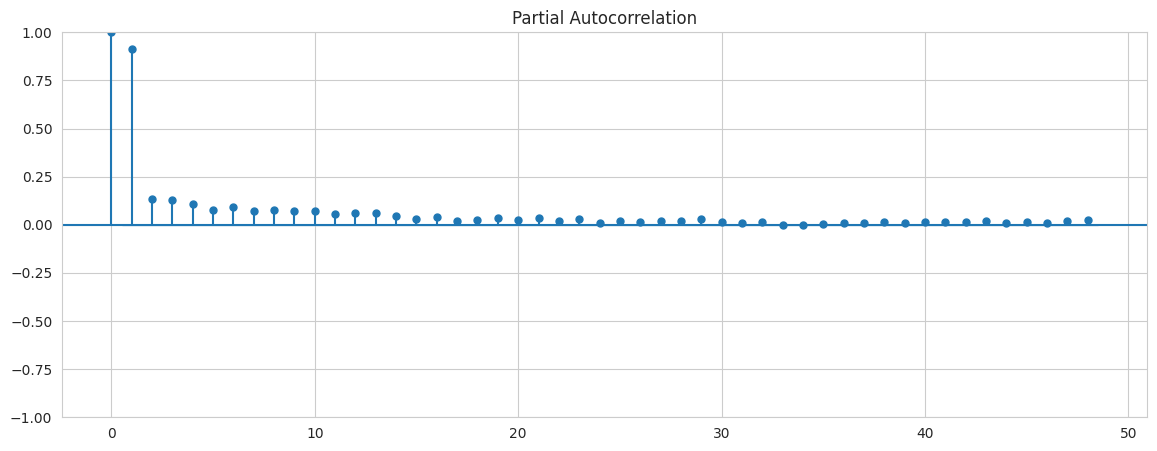

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts, lags=48)
plt.show()

plot_pacf(ts, lags=48)
plt.show()


## Stationarity Test (Augmented Dickey-Fuller)

The Augmented Dickey-Fuller (ADF) test checks for the presence of a unit root,
which indicates non-stationarity.

- Null hypothesis: the series is non-stationary
- Alternative hypothesis: the series is stationary

The high p-value suggests we cannot reject the null hypothesis,
confirming that the series is non-stationary.

This reinforces the need for:
- decomposition
- differencing (for classical models)
- deep learning approaches that handle non-stationary data naturally


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(ts.dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -9.925834164031048
p-value: 2.9087496272848465e-17


## Seasonal Strength

Seasonal strength quantifies how much of the variance in the series
is explained by the seasonal component.

A high seasonal strength value indicates that:
- seasonality is a dominant factor in the data
- models must explicitly account for periodic patterns

This metric supports the use of:
- seasonal baselines
- models with explicit or learned seasonality representations


In [19]:
seasonal_strength = 1 - (
    np.var(result.resid) / np.var(result.resid + result.seasonal)
)

seasonal_strength


np.float64(0.34945426705270655)

## Distribution and Potential Outliers

Analyzing the distribution of electricity load values provides insight into:
- typical operating ranges
- skewness and heavy tails
- extreme values that may correspond to anomalies

The presence of heavy tails suggests that:
- simple static thresholds may be insufficient
- anomaly detection should consider dynamic or probabilistic thresholds


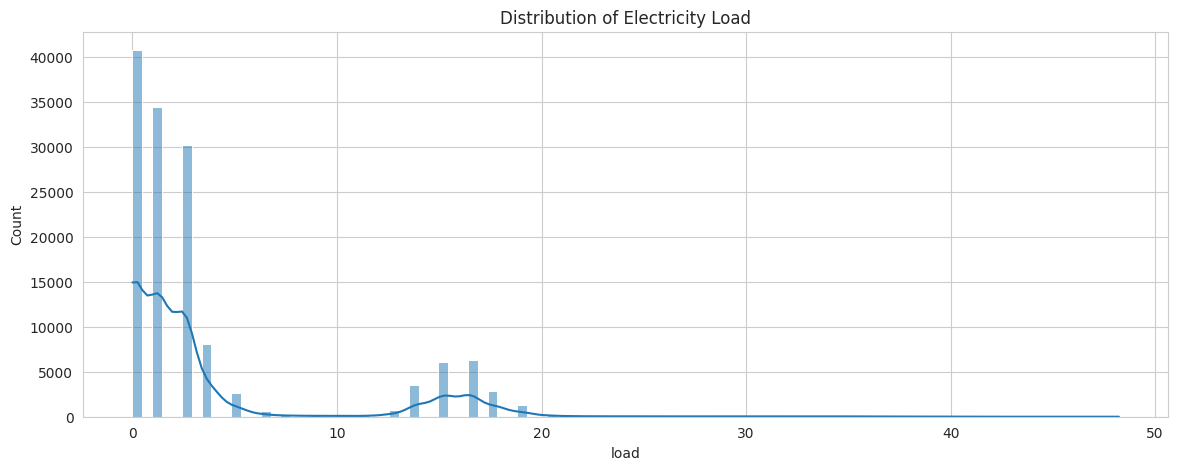

In [20]:
sns.histplot(ts, bins=100, kde=True)
plt.title("Distribution of Electricity Load")
plt.show()


## Exploration Summary 

Based on visual inspection and statistical diagnostics, the following key
characteristics of the electricity load time series are observed:

### 1. Trend and Variance Dynamics
Rolling statistics show that both the mean and variance of the series
change over time. There are clear regime-like shifts where the level and
volatility of the load differ significantly across periods.

This indicates:
- Non-constant variance (heteroscedasticity)
- Structural changes in consumption behavior
- Potential concept drift over long horizons

These properties make static models fragile and motivate adaptive or
window-based learning approaches.

---

### 2. Decomposition Insights
STL decomposition reveals that:
- The trend component exhibits abrupt level changes rather than smooth evolution
- Seasonal patterns are present but vary in strength over time
- The residual component contains heavy-tailed noise and frequent spikes

The residual structure suggests that anomalies are not isolated rare points,
but rather occur in clusters and regime-dependent patterns.

---

### 3. Autocorrelation Structure
Autocorrelation analysis shows:
- Extremely strong persistence across many lags
- Slow decay of autocorrelation values
- Significant dependence well beyond short horizons

Partial autocorrelation highlights a strong short-lag dependency with
gradually diminishing influence, indicating that:
- Past observations carry long-term predictive signal
- Temporal dependencies are complex and not easily captured by low-order
  autoregressive models

---

### 4. Stationarity Test Interpretation
The Augmented Dickey-Fuller test strongly rejects the null hypothesis of
non-stationarity (very low p-value).

However, this statistical stationarity contrasts with:
- Visible trend shifts
- Changing variance
- Structural regime changes

This highlights an important practical insight:
statistical stationarity does not imply modeling stationarity.
Despite passing the ADF test, the series remains challenging for
classical stationary models in real-world forecasting settings.

---

### 5. Seasonality Strength
The computed seasonal strength (~0.35) indicates that:
- Seasonality explains a meaningful but not dominant portion of the variance
- A large fraction of variability remains unexplained by periodic structure

This suggests that:
- Purely seasonal models are insufficient
- Models must jointly learn trend, noise, and irregular dynamics
- Learned representations (e.g. deep learning) are well suited

---

### 6. Distributional Characteristics
The load distribution is highly skewed with heavy tails.
Extreme values are frequent rather than exceptional, implying that:
- Fixed thresholds are likely to fail for anomaly detection
- Probabilistic or adaptive thresholds are required
- Forecast-error–based anomaly detection is more appropriate than
  pointwise statistical rules

---

### Overall Implications for Modeling

- Despite statistical stationarity, the series exhibits strong non-stationary
  behavior in practice
- Seasonality alone does not dominate the signal
- Long memory, regime shifts, and heavy-tailed residuals are central challenges

These characteristics strongly motivate:
- Window-based forecasting models
- Deep learning architectures that can adapt to changing patterns
- Forecasting-based anomaly detection using dynamic confidence bounds
